# Setup

In [3]:
"""
Add parent directory to current path
"""
import os.path
import sys
p = os.path.abspath('..')
if p not in sys.path:
    sys.path.insert(0,p)
    
"""
Add tiger-env directory to current path
Still not sure why this is needed.
"""
p = os.path.abspath('../../custom_envs/gym-tiger')
if p not in sys.path:
    sys.path.insert(0, p)
    

"""
Enable hot-reloading
"""    
from notebook_utils import import_module_by_name, reload_module_by_name

def reload():
    reload_module_by_name('rlpomdp.models.qlearner', 'QLearner')
    reload_module_by_name('rlpomdp.feature_transformers.simple', 'TigerFeatureTransformer')
    global QLearner, TigerFeatureTransformer
    from rlpomdp.models.qlearner import QLearner

# Setup ENV and Model

In [11]:
import gym
import gym_tiger
import matplotlib.pyplot as plt
from rlpomdp.utils import play_one, plot_running_avg
from rlpomdp.models.qlearner import QLearner

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
model = QLearner(env, alpha=.001, gamma=.9)
eps = 1
n = 0
ot = env.reset()

if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

# Take one action and update Q

$$
Q(s_{t-1}, a_{t-1}) = Q(s_{t-1}, a_{t-1}) + \alpha \big[ r_t + \gamma \cdot Q(s_t, a_t) - Q(s_{t-1}, a_{t-1}) \big]
$$

In [12]:
def print_model(model, n=''):
    print('\n')
    print('{: >10} \tOPEN LEFT | OPEN RIGHT | LISTEN'.format(n))
    print('\t\t--------- | ---------- | ------')
    print("GROWL LEFT {: >14} | {: >10} | {: >6}".format(*model.Q[0].round(2)))
    print("GROWL RIGHT: {: >12} | {: >10} | {: >6}".format(*model.Q[1].round(2)))
    print("START: {: >18} | {: >10} | {: >6}".format(*model.Q[2].round(2)))
    print("END: {: >20} | {: >10} | {: >6}".format(*model.Q[3].round(2)))
    print('\n')

print_model(model)
otm1 = ot
atm1 = model.sample_action(otm1, eps)
ot, r, done, info = env.step(atm1)
at = model.best_action(ot)
model.update(otm1, atm1, r, ot, at)
_otm1 = env.translate_obs(otm1)
_atm1 = env.translate_action(atm1)
print(_otm1, ',', _atm1, ',', r)
print_model(model)



           	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT           0.35 |       0.74 |  -0.45
GROWL RIGHT:         0.34 |       0.93 |   0.04
START:              -0.25 |      -0.26 |  -0.79
END:                -0.86 |       0.32 |    0.1


START , LISTEN , -1


           	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT           0.35 |       0.74 |  -0.45
GROWL RIGHT:         0.34 |       0.93 |   0.04
START:              -0.25 |      -0.26 |  -0.79
END:                -0.86 |       0.32 |    0.1




# Play 1 Episode

In [13]:
play_one(env, model, eps, verbose=True)

o_t-1       | a_t-1      | r     | o_t         | a_t       
-------------------------------------------------------
START       | OPEN_LEFT  | -100  | END         | OPEN_RIGHT


-100

In [14]:
print_model(model)



           	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT           0.35 |       0.74 |  -0.45
GROWL RIGHT:         0.34 |       0.93 |   0.04
START:              -0.35 |      -0.26 |  -0.79
END:                -0.86 |       0.32 |    0.1




# Play 5K Episodes



         0 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT           0.35 |       0.74 |  -0.45
GROWL RIGHT:         0.34 |       0.93 |   0.04
START:              -0.35 |      -0.36 |  -0.79
END:                -0.86 |       0.32 |    0.1




      1000 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -8.14 |      -4.99 |  -4.99
GROWL RIGHT:        -4.85 |      -6.17 |  -4.79
START:              -2.21 |      -2.16 |  -2.11
END:                -0.86 |       0.32 |    0.1




      2000 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -17.0 |      -8.56 |  -8.57
GROWL RIGHT:        -8.64 |     -14.09 |  -8.57
START:              -5.19 |      -5.22 |  -5.18
END:                -0.86 |       0.32 |    0.1




      3000 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT         -27.95 |      -9.95 |   -9.9
GROWL RIGHT:        -9.99 |     -26.69 |   -9.9
ST

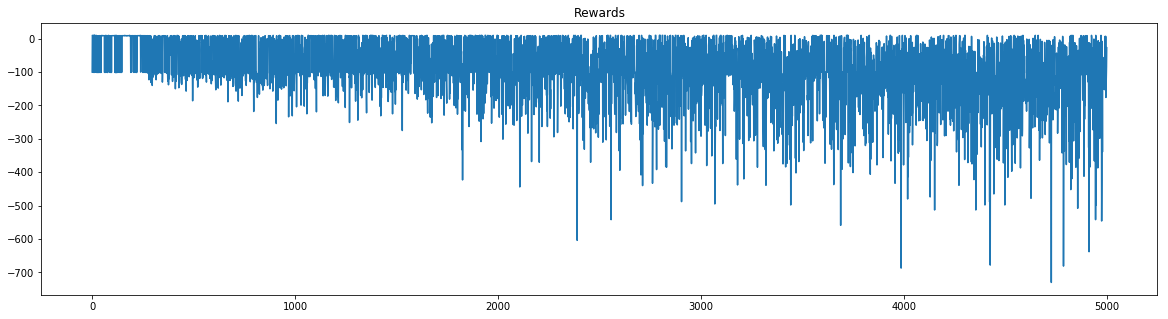

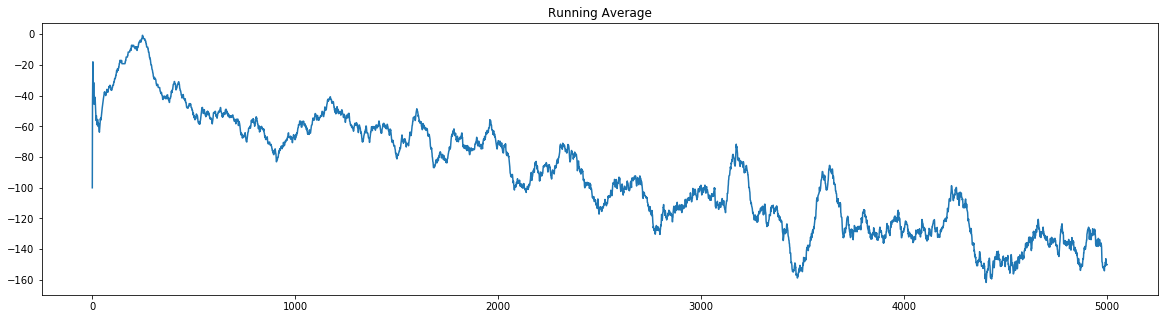

In [15]:
N = 5000
totalrewards = np.empty(N)
for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps)
    totalrewards[n] = totalreward
    if n % (N/5) == 0:
        print_model(model, n=n)

print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", totalrewards.sum())

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(totalrewards)
ax.set_title("Rewards")

print_model(model, n=n)
plot_running_avg(totalrewards)